# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date:  2023**

# Notebook 3A. WSB posts labelling using trained model

## 2.0 Imports

In [253]:
# Standard Libraries for data manipulation
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import string
import joblib

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


# Set the option to display full content without truncation
pd.set_option('display.max_colwidth', None)  # or you could use a large number instead of None

In [254]:
df_all = pd.read_csv('../data/reddit_cleaned.csv')

In [255]:
# df = df_all.sample(10000).copy()
df = df_all.copy()

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414449 entries, 0 to 1414448
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   id                   1414449 non-null  object 
 1   author               1414449 non-null  object 
 2   created              1414449 non-null  object 
 3   removed              1414449 non-null  int64  
 4   deleted              1414449 non-null  int64  
 5   is_self              1414449 non-null  int64  
 6   is_video             1414449 non-null  int64  
 7   title                1414444 non-null  object 
 8   link_flair_text      1414449 non-null  object 
 9   upvote_ratio         1414449 non-null  float64
 10  score                1414449 non-null  int64  
 11  num_comments         1414449 non-null  int64  
 12  selftext             979816 non-null   object 
 13  shortlink            1414449 non-null  object 
 14  FolderName           1414449 non-null  object 
 15

In [257]:
df.describe()

,removed,deleted,is_self,is_video,upvote_ratio,score,num_comments,word_count_selftext,word_count_title
count,1.414449e+06,1.414449e+06,1.414449e+06,1.414449e+06,1.414449e+06,1.414449e+06,1.414449e+06,1.414449e+06,1.414449e+06
mean,6.608404e-01,9.146671e-02,6.327531e-01,2.029624e-02,8.866556e-01,8.622449e+01,1.187502e+01,3.549445e+01,9.976586e+00
std,4.734243e-01,2.882718e-01,4.820547e-01,1.410118e-01,1.893697e-01,1.664295e+03,3.070679e+02,1.423286e+02,8.522152e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.300000e-01,1.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00
50%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
75%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,6.000000e+00,1.000000e+00,1.300000e+01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.994890e+05,9.669400e+04,1.441000e+04,1.430000e+02


In [258]:
df['id'].nunique() == df.shape[0]

True

In [259]:
df.isna().sum()/df.shape[0]

id                     0.000000
author                 0.000000
created                0.000000
removed                0.000000
deleted                0.000000
is_self                0.000000
is_video               0.000000
title                  0.000004
link_flair_text        0.000000
upvote_ratio           0.000000
score                  0.000000
num_comments           0.000000
selftext               0.307281
shortlink              0.000000
FolderName             0.000000
word_count_selftext    0.000000
word_count_title       0.000000
date                   0.000000
dtype: float64

In [260]:
df[ df['selftext'].isna()]

,id,author,created,removed,deleted,is_self,is_video,title,link_flair_text,upvote_ratio,score,num_comments,selftext,shortlink,FolderName,word_count_selftext,word_count_title,date
4,l6vhy3,grebfar,2021-01-28 12:32:53,0,0,1,0,GME Containment Zone 1 for 28 January,Mods,0.96,18374,84416,NaN,https://redd.it/l6vhy3,wallstreetbets,1,7,2021-01-28
8,l7v9o8,wallstreetboyfriend,2021-01-29 15:26:04,0,0,1,0,GME What About Second Breakfast Club Megathread,none,0.95,31291,77133,NaN,https://redd.it/l7v9o8,wallstreetbets,1,7,2021-01-29
28,l78uct,DeepFuckingValue,2021-01-28 21:06:23,0,0,0,0,GME YOLO update — Jan 28 2021,YOLO,0.95,268017,24240,NaN,https://redd.it/l78uct,wallstreetbets,1,7,2021-01-28
32,l846a1,DeepFuckingValue,2021-01-29 21:04:45,0,0,0,0,GME YOLO month-end update — Jan 2021,YOLO,0.95,241892,21087,NaN,https://redd.it/l846a1,wallstreetbets,1,7,2021-01-29
34,lb6jld,DeepFuckingValue,2021-02-02 21:11:48,0,0,0,0,GME YOLO update — Feb 2 2021,YOLO,0.90,147738,18108,NaN,https://redd.it/lb6jld,wallstreetbets,1,7,2021-02-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414434,l7g95t,PARILIZEDpArrOT243,2021-01-29 02:14:19,1,0,0,0,Of course they deny it,News,1.00,1,0,NaN,https://redd.it/l7g95t,wallstreetbets,1,5,2021-01-29
1414438,l7g985,stag62,2021-01-29 02:14:25,1,0,0,0,"HEY, WSJ, SHOULD PROBS VET YOUR SOURCES. EX. A, THE TOP POST HERE.",News,1.00,1,0,NaN,https://redd.it/l7g985,wallstreetbets,1,13,2021-01-29
1414441,l7g9a3,andreamackie13,2021-01-29 02:14:29,1,0,0,0,TD AMERITRADE Email Stating They Won’t Prevent Clients From Buying and Selling Volatile Stocks,News,1.00,1,0,NaN,https://redd.it/l7g9a3,wallstreetbets,1,14,2021-01-29
1414443,l7g9b5,Lanineo,2021-01-29 02:14:31,1,0,0,0,They see us,News,1.00,1,0,NaN,https://redd.it/l7g9b5,wallstreetbets,1,3,2021-01-29


In [261]:
# Dropping rows that have NaN values
df = df.dropna()

In [262]:
df[ df['selftext'].isna() ]

,id,author,created,removed,deleted,is_self,is_video,title,link_flair_text,upvote_ratio,score,num_comments,selftext,shortlink,FolderName,word_count_selftext,word_count_title,date


## 2.1. Cleaning the text (pre-processing)

In [263]:
# punctuation and anything except for letters is stripped away, also empty spaces go away. 

# Emojis are stripped off!!!! NB! 

if False:
    
    cleaned_df = df.copy()
    # to replace any character that is not a lowercase or uppercase letter with a single space
    # then to replace one or more whitespace characters (\s+) with a single space
    # then to replace '/n' with empty spaces
    # then to remove all types of whitespace characters at the ends of the string
    # cleaned_df["Text"] = cleaned_df["Text"].replace("\n", "").str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")


    # First, replace newline characters with an empty string for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace("\n", "", regex=False)

    # Then, replace non-alphabetic characters with a space for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace(r"[^a-zA-Z]", " ", regex=True)

    # Then, replace multiple spaces with a single space for each element
    cleaned_df["Text"] = cleaned_df["Text"].str.replace(r"\s+", " ", regex=True)

    # Finally, strip leading and trailing spaces from each element
    cleaned_df["Text"] = cleaned_df["Text"].str.strip()

    df=cleaned_df.copy()

I am going to exclude information and unclear from the dataset. negative will be assugned rating 0, and positive will be assigned trating 1.  

### 2.1.1. Custom Tokenization function

In [264]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = [] #"you're", 'billion',"that's", "let's", 'gamestop', 'gme' ]

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [265]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document


#EXTRA
#to modify the default parameters of my_tokenizer_pattern we can use a lambda function in-place:
#count_vectorizer = CountVectorizer(tokenizer=lambda document: my_tokenizer(document, lemmatization=True, stemming=False))

#what if we only wanted to extract letters, without numeric characters
#consider changing the pattern to pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"

## 2.2. Yes only

In [266]:
# loaded_grid = joblib.load('../model/labelled_yes_linear_grid.pkl')

In [267]:
# Load the entire pipeline from the file
pipeline_loaded = joblib.load('../model/labelled_yes_linear_pipeline.pkl')

In [268]:
# Predicting new data based on TITLE

# Assign new X variable 
X_new = df['title']

# Apply the pipeline to the WSB dataset
predictions = pipeline_loaded.predict(X_new)

# Review and process predictions as needed
df['predictions_yes_only_title'] = predictions
# df.to_csv('predictions_y_only_title.csv', index=False)

In [269]:
# Predicting new data based on SELFTEXT

# Assign new X variable 
X_new = df['selftext']

# Apply the pipeline to the WSB dataset
predictions = pipeline_loaded.predict(X_new)

# Review and process predictions as needed
df['predictions_yes_only_selftext'] = predictions
#df.to_csv('predictions_y_only_selftext.csv', index=False)

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 979811 entries, 0 to 1414448
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             979811 non-null  object 
 1   author                         979811 non-null  object 
 2   created                        979811 non-null  object 
 3   removed                        979811 non-null  int64  
 4   deleted                        979811 non-null  int64  
 5   is_self                        979811 non-null  int64  
 6   is_video                       979811 non-null  int64  
 7   title                          979811 non-null  object 
 8   link_flair_text                979811 non-null  object 
 9   upvote_ratio                   979811 non-null  float64
 10  score                          979811 non-null  int64  
 11  num_comments                   979811 non-null  int64  
 12  selftext                       979

## 2.2. Yes and Maybe

In [271]:
# Load the entire pipeline from the file
pipeline_loaded = joblib.load('../model/labelled_ymaybe_linear_pipeline.pkl')

In [272]:
# Predicting new data based on TITLE

# Assign new X variable 
X_new = df['title']

# Apply the pipeline to the WSB dataset
predictions = pipeline_loaded.predict(X_new)

# Review and process predictions as needed
df['predictions_ymaybe_title'] = predictions

In [273]:
# Predicting new data based on SELFTEXT

# Assign new X variable 
X_new = df['selftext']

# Apply the pipeline to the WSB dataset
predictions = pipeline_loaded.predict(X_new)

# Review and process predictions as needed
df['predictions_ymaybe_selftext'] = predictions

## 2.2. No only

In [274]:
# Load the entire pipeline from the file
pipeline_loaded = joblib.load('../model/labelled_no_linear_pipeline.pkl')

In [275]:
# Predicting new data based on TITLE

# Assign new X variable 
X_new = df['title']

# Apply the pipeline to the WSB dataset
predictions = pipeline_loaded.predict(X_new)

# Review and process predictions as needed
df['predictions_no_title'] = predictions

In [276]:
# Predicting new data based on SELFTEXT

# Assign new X variable 
X_new = df['selftext']

# Apply the pipeline to the WSB dataset
predictions = pipeline_loaded.predict(X_new)

# Review and process predictions as needed
df['predictions_no_selftext'] = predictions

In [277]:
#df.to_csv('1000_random_predictions.csv', index=False)

## 2.x. Analysing the ratings distribution

In [278]:

total_records = len(df)
records_with_1 = df['predictions_yes_only_title'].value_counts().get(1, 0)
percentage_with_1 = (records_with_1 / total_records) * 100
print(f"Percentage of records with 1 in 'predictions_yes_only_title': {percentage_with_1:.2f}%")

records_with_1 = df['predictions_ymaybe_title'].value_counts().get(1, 0)
percentage_with_1 = (records_with_1 / total_records) * 100
print(f"Percentage of records with 1 in 'predictions_ymaybe_title': {percentage_with_1:.2f}%")

records_with_1 = df['predictions_no_title'].value_counts().get(1, 0)
percentage_with_1 = (records_with_1 / total_records) * 100
print(f"Percentage of records with 1 in 'predictions_no_title': {percentage_with_1:.2f}%")

print('****')

records_with_1 = df['predictions_yes_only_selftext'].value_counts().get(1, 0)
percentage_with_1 = (records_with_1 / total_records) * 100
print(f"Percentage of records with 1 in 'predictions_yes_only_selftext': {percentage_with_1:.2f}%")

records_with_1 = df['predictions_ymaybe_selftext'].value_counts().get(1, 0)
percentage_with_1 = (records_with_1 / total_records) * 100
print(f"Percentage of records with 1 in 'predictions_ymaybe_selftext': {percentage_with_1:.2f}%")

records_with_1 = df['predictions_no_selftext'].value_counts().get(1, 0)
percentage_with_1 = (records_with_1 / total_records) * 100
print(f"Percentage of records with 1 in 'predictions_no_selftext': {percentage_with_1:.2f}%")

Percentage of records with 1 in 'predictions_yes_only_title': 10.19%
Percentage of records with 1 in 'predictions_ymaybe_title': 20.20%
Percentage of records with 1 in 'predictions_no_title': 0.07%
****
Percentage of records with 1 in 'predictions_yes_only_selftext': 10.72%
Percentage of records with 1 in 'predictions_ymaybe_selftext': 14.52%
Percentage of records with 1 in 'predictions_no_selftext': 0.01%


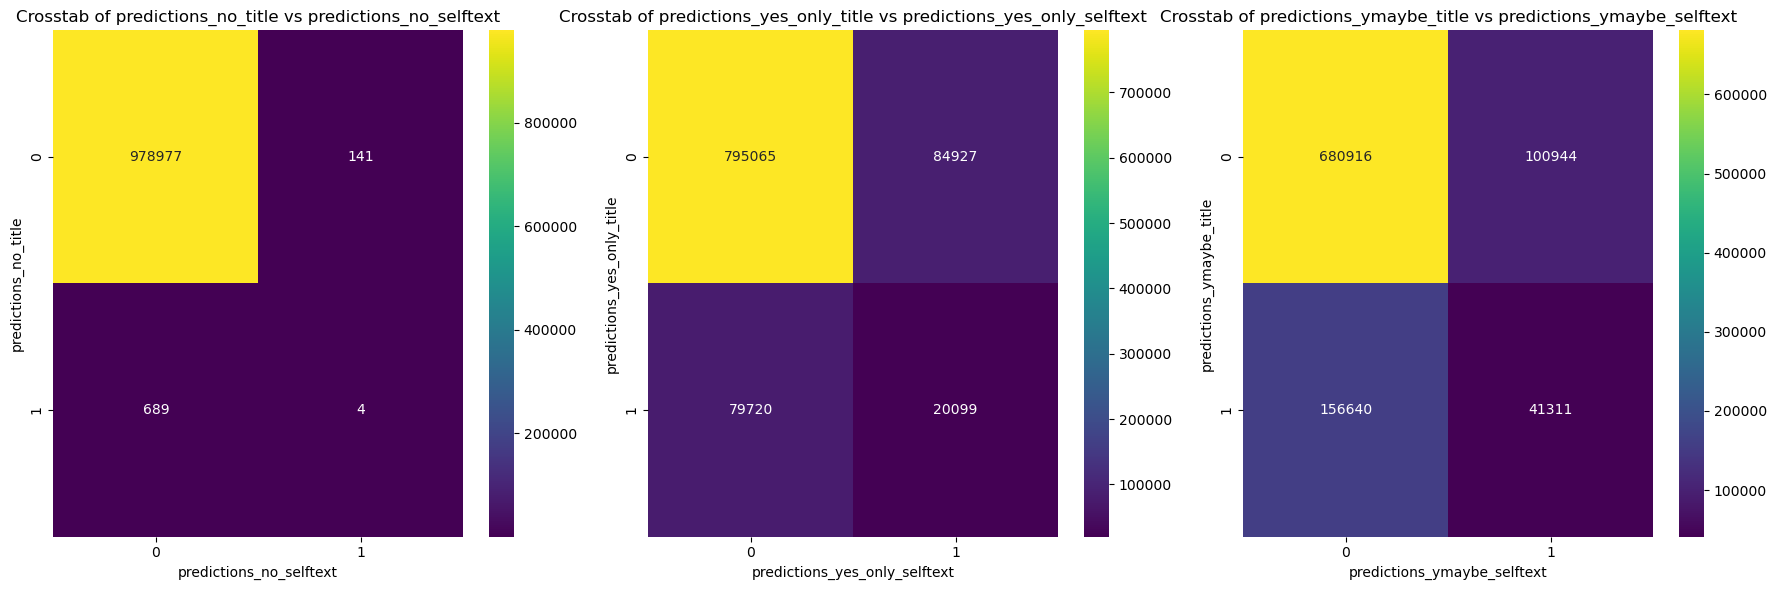

In [279]:
# Column pairs for crosstabs
column_pairs = [
    ('predictions_no_title', 'predictions_no_selftext'),
    ('predictions_yes_only_title', 'predictions_yes_only_selftext'),
    ('predictions_ymaybe_title', 'predictions_ymaybe_selftext')
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for ax, (col1, col2) in zip(axes, column_pairs):
    crosstab = pd.crosstab(df[col1], df[col2])
    sns.heatmap(crosstab, annot=True, fmt="d", cmap='viridis', ax=ax)
    ax.set_title(f'Crosstab of {col1} vs {col2}')
    ax.set_xlabel(col2)
    ax.set_ylabel(col1)

plt.tight_layout()
plt.show()

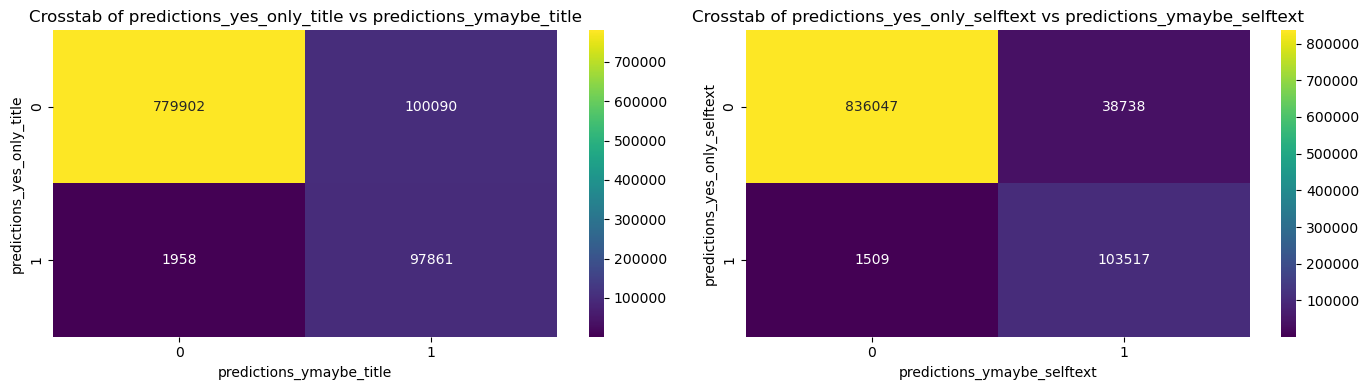

In [280]:
# Column pairs for crosstabs
column_pairs = [
    ('predictions_yes_only_title', 'predictions_ymaybe_title'),
    ('predictions_yes_only_selftext', 'predictions_ymaybe_selftext')
]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
for ax, (col1, col2) in zip(axes, column_pairs):
    crosstab = pd.crosstab(df[col1], df[col2])
    sns.heatmap(crosstab, annot=True, fmt="d", cmap='viridis', ax=ax)
    ax.set_title(f'Crosstab of {col1} vs {col2}')
    ax.set_xlabel(col2)
    ax.set_ylabel(col1)

plt.tight_layout()
plt.show()

#### Creating Bull and Bear Score column

In [281]:
# Introducing 2 new columns with a calculated aggregate bull and bear score that indicate whether this post is overall bullish or bearish or neither

# Calculating 'bull_score'
df['bull_score'] = np.ceil((
    (df['predictions_yes_only_title']).astype(int) +
    (df['predictions_yes_only_selftext']).astype(int) +
    (df['predictions_ymaybe_title']).astype(int) +
    (df['predictions_ymaybe_selftext']).astype(int)
) / 4)  # Divided by the number of columns, then rounded up

# Calculating 'bear_score'
df['bear_score'] = np.ceil((
    (df['predictions_no_title']).astype(int) +
    (df['predictions_no_selftext']).astype(int)
) / 2)  # Divided by the number of columns, then rounded up

In [294]:
# THis code is for examining text of various messages and their corresponding ratings
filtered_posts = df[df['title'].str.contains('sell GME', case=False, na=False)]
filtered_posts.sample(3)

,id,author,created,removed,deleted,is_self,is_video,title,link_flair_text,upvote_ratio,...,word_count_title,date,predictions_yes_only_title,predictions_yes_only_selftext,predictions_ymaybe_title,predictions_ymaybe_selftext,predictions_no_title,predictions_no_selftext,bull_score,bear_score
98855,m20kx0,[deleted],2021-03-10 15:52:47,1,1,1,0,Wouldnt it be smart if we all sell GME and buy it again,Discussion,0.22,...,13,2021-03-10,0,0,0,0,0,0,0.0,0.0
1338047,l6xpr0,robinhoodcom,2021-01-28 14:18:12,1,0,1,0,NOK NOK and DON'T NOT SELL GME,Discussion,1.00,...,7,2021-01-28,0,0,0,0,0,0,0.0,0.0
461567,ld8wz3,throwawayy875,2021-02-05 15:01:04,0,0,1,0,"If you sell GME for a loss, you’re not only a retard, but a retard pushover",Discussion,0.95,...,16,2021-02-05,0,0,0,0,0,0,0.0,0.0


In [297]:
# Filter rows where all newly created ratings indicate intent to buy

filtered_rows_0 = df[df['bear_score'] == 0]
filtered_rows_1.sample(2)

#filtered_rows_1.to_csv('../data/intent_1_predictions.csv', index=False)

,id,author,created,removed,deleted,is_self,is_video,title,link_flair_text,upvote_ratio,...,word_count_title,date,predictions_yes_only_title,predictions_yes_only_selftext,predictions_ymaybe_title,predictions_ymaybe_selftext,predictions_no_title,predictions_no_selftext,bull_score,bear_score
169611,nvx8z6,Traderx1583,2021-06-09 14:28:08,0,0,1,0,"$3,500,000 and more in OCGN to the MOON",YOLO,0.61,...,8,2021-06-09,1,1,1,1,0,0,1.0,0.0
780227,l684wh,ChampsGotGame,2021-01-27 16:25:33,0,0,1,0,Repenting for Selling - IM FULLY BACK,YOLO,1.00,...,7,2021-01-27,1,1,1,1,0,0,1.0,0.0


In [295]:
# Filter rows where all newly created ratings indicate intent to sell
filtered_rows_0 = df[df['bear_score'] == 1]
filtered_rows_0.sample(2)

# filtered_rows_0.to_csv('../data/intent_0_predictions.csv', index=False)

,id,author,created,removed,deleted,is_self,is_video,title,link_flair_text,upvote_ratio,...,word_count_title,date,predictions_yes_only_title,predictions_yes_only_selftext,predictions_ymaybe_title,predictions_ymaybe_selftext,predictions_no_title,predictions_no_selftext,bull_score,bear_score
853229,oqc5s1,Tittyboi34,2021-07-23 21:38:37,1,0,1,0,$SNAP puts,Discussion,1.0,...,2,2021-07-23,0,0,0,0,1,0,0.0,1.0
692114,lilofg,Pacificsurge01,2021-02-12 21:49:25,1,0,1,0,GME Puts Expired!,none,1.0,...,3,2021-02-12,0,0,0,0,1,0,0.0,1.0


In [298]:
# Saving the dataset for further work in Notebook X

df.to_csv('../data/dataset_bull_bear.csv', index=False)

## 5.X. Grouping by author

In [285]:
# Group by the 'author' column and aggregate other columns
df_agg_by_author = df.groupby([df['author']]).agg({
    'id':'count', 
    'score': 'mean',
    'num_comments':'sum',
    'deleted':'sum',
    'removed':'sum',
    'upvote_ratio':'sum',
    'title':'count',
    'selftext':'count',
    'word_count_selftext':'mean',
    'word_count_title':'mean',
    'predictions_yes_only_title':'sum',
    'predictions_yes_only_selftext':'sum', 
    'predictions_ymaybe_title':'sum',
    'predictions_ymaybe_selftext':'sum', 
    'predictions_no_title':'sum',
    'predictions_no_selftext':'sum'
}).reset_index().rename(columns={
    'id': 'total_posts',
    'score': 'average_score',
    'num_comments': 'total_comments',
    'deleted':'total_deleted',
    'removed':'total_removed',
    'upvote_ratio':'total_upvote_ratio',
    'title':'total_titles',
    'selftext':'total_selftexts',
    'word_count_selftext':'average_word_count_selftext',
    'word_count_title':'average_word_count_title',
    'predictions_yes_only_title': 'sum_yes_only_title',
    'predictions_yes_only_selftext': 'sum_yes_only_selftext', 
    'predictions_ymaybe_title':'sum_ymaybe_title',
    'predictions_ymaybe_selftext': 'sum_ymaybe_selftext', 
    'predictions_no_title': 'sum_no_title',
    'predictions_no_selftext':'sum_no_selftext'
})

In [286]:
df_agg_by_author

,author,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,total_titles,total_selftexts,average_word_count_selftext,average_word_count_title,sum_yes_only_title,sum_yes_only_selftext,sum_ymaybe_title,sum_ymaybe_selftext,sum_no_title,sum_no_selftext
0,-----------------in,1,1.000000,0,0,1,1.00,1,1,1.000000,4.0,1,0,1,0,0,0
1,---------II---------,1,1.000000,10,0,0,1.00,1,1,276.000000,11.0,0,0,0,1,0,0
2,--------Username----,1,1.000000,1,0,1,1.00,1,1,1.000000,5.0,0,0,0,0,0,0
3,--------sam,1,10.000000,13,0,0,1.00,1,1,22.000000,5.0,0,0,0,0,0,0
4,------dudpool------,1,2.000000,2,0,0,1.00,1,1,128.000000,7.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449851,zzzzja,1,0.000000,0,0,1,0.50,1,1,1.000000,1.0,0,0,0,0,0,0
449852,zzzzllll,1,1.000000,1,0,1,1.00,1,1,1.000000,3.0,0,0,0,0,0,0
449853,zzzzoooo,6,1.166667,87,0,1,3.55,6,6,99.666667,6.5,0,1,1,3,0,0
449854,zzzzzxx,1,1.000000,0,0,0,0.66,1,1,114.000000,4.0,0,1,0,1,0,0


In [287]:
# Sorting the filtering results by the AVERAGE SCORE
df_agg_by_author['total_pct_removed'] = df_agg_by_author['total_removed'] / df_agg_by_author['total_posts'] *100

df_authors= df_agg_by_author.sort_values(by='total_pct_removed', ascending=False).head(100)
df_authors.head(10)

,author,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,total_titles,total_selftexts,average_word_count_selftext,average_word_count_title,sum_yes_only_title,sum_yes_only_selftext,sum_ymaybe_title,sum_ymaybe_selftext,sum_no_title,sum_no_selftext,total_pct_removed
0,-----------------in,1,1.0,0,0,1,1.0,1,1,1.0,4.000000,1,0,1,0,0,0,100.0
255017,Turbulent-Plan-9951,1,1.0,1,0,1,1.0,1,1,1.0,4.000000,0,0,0,0,0,0,100.0
255015,Turbulent-Pea-4210,1,1.0,0,0,1,1.0,1,1,1.0,4.000000,0,0,0,0,0,0,100.0
255014,Turbulent-Owl-2072,1,1.0,1,0,1,1.0,1,1,1.0,7.000000,0,0,0,0,0,0,100.0
255013,Turbulent-Orchid5252,1,1.0,0,0,1,1.0,1,1,1.0,2.000000,0,0,0,0,0,0,100.0
255011,Turbulent-Network480,2,1.0,0,0,2,2.0,2,2,1.0,15.000000,1,0,2,0,0,0,100.0
255010,Turbulent-Mood-6926,1,1.0,0,0,1,1.0,1,1,1.0,3.000000,0,0,0,0,0,0,100.0
255009,Turbulent-Love-588,3,1.0,3,0,3,3.0,3,3,1.0,15.333333,1,0,1,0,0,0,100.0
255008,Turbulent-Lock16,1,1.0,0,0,1,1.0,1,1,1.0,2.000000,0,0,0,0,0,0,100.0
255007,Turbulent-Lion6518,1,1.0,1,0,1,1.0,1,1,1.0,14.000000,0,0,0,0,0,0,100.0


Seeing a lot of bots, where 100% of their posts have been deleted by the moderators. I want to drop those spammers from my analysis. The code below shows that 63.6% of authors were actually spammers. This leaves me with a substantially smaller number of authors (163,768).

In [288]:
# Calculating how many rows will be dropped if I deleted all the authors where 100% of their posts have been removed by the moderators
rows_to_drop = df_agg_by_author[df_agg_by_author['total_pct_removed'] == 100].shape[0]
print(f"Number of rows to be dropped: {rows_to_drop}")

total_authors = df_agg_by_author.shape[0]
percentage_to_drop = (rows_to_drop / total_authors) * 100
print(f"Percentage of authors to be dropped: {percentage_to_drop:.2f}%")

Number of rows to be dropped: 286088
Percentage of authors to be dropped: 63.60%


In [289]:
# Dropping rows with spammers (where 100% of their posts have been removed by moderators) 
# Keep rows where 'total_pct_removed' is less than 100
df_agg_by_author = df_agg_by_author[df_agg_by_author['total_pct_removed'] < 100]

In [290]:
# Sorting the filtering results by the AVERAGE SCORE
df_authors= df_agg_by_author.sort_values(by='sum_yes_only_title', ascending=False).head(10)
df_authors.head(10)

,author,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,total_titles,total_selftexts,average_word_count_selftext,average_word_count_title,sum_yes_only_title,sum_yes_only_selftext,sum_ymaybe_title,sum_ymaybe_selftext,sum_no_title,sum_no_selftext,total_pct_removed
274793,[deleted],199584,18.271089,858704,129374,199173,179262.23,199584,199584,1.214727,10.802479,26066,70,47304,120,119,0,99.794072
245498,TheTeeKey,77,7.636364,209,0,0,68.70,77,77,49.168831,5.155844,31,16,37,17,0,0,0.000000
283765,apooroldinvestor,188,11.840426,5335,0,27,135.88,188,188,92.271277,9.409574,27,78,44,96,0,0,14.361702
383937,nmstanley32,314,100.229299,3553,0,33,260.31,314,314,11.589172,20.105096,24,13,60,56,0,0,10.509554
231918,StonkChief420,110,27.781818,895,0,4,91.72,110,110,25.409091,7.490909,22,18,34,32,0,0,3.636364
299202,canary1988,207,56.932367,1973,0,9,165.07,207,207,18.859903,11.806763,21,17,37,41,0,0,4.347826
171160,No_Seesaw1134,33,12.515152,189,0,4,26.96,33,33,325.575758,12.363636,19,0,29,3,0,0,12.121212
1884,16FX,23,7.043478,151,0,0,21.41,23,23,325.260870,8.217391,18,18,18,16,0,0,0.000000
11555,Adventurous-Pay-2995,70,12.342857,172,0,16,60.65,70,70,25.814286,7.914286,16,19,27,38,0,0,22.857143
332303,gmorgan99,145,406.703448,6622,0,1,131.80,145,145,65.696552,9.413793,15,22,26,44,0,0,0.689655


In [291]:
df.columns

Index(['id', 'author', 'created', 'removed', 'deleted', 'is_self', 'is_video',
       'title', 'link_flair_text', 'upvote_ratio', 'score', 'num_comments',
       'selftext', 'shortlink', 'FolderName', 'word_count_selftext',
       'word_count_title', 'date', 'predictions_yes_only_title',
       'predictions_yes_only_selftext', 'predictions_ymaybe_title',
       'predictions_ymaybe_selftext', 'predictions_no_title',
       'predictions_no_selftext', 'bull_score', 'bear_score'],
      dtype='object')

In [292]:
df_agg_by_author.describe()

,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,total_titles,total_selftexts,average_word_count_selftext,average_word_count_title,sum_yes_only_title,sum_yes_only_selftext,sum_ymaybe_title,sum_ymaybe_selftext,sum_no_title,sum_no_selftext,total_pct_removed
count,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000,163768.000000
mean,3.622735,61.361363,59.764191,0.789983,1.786521,3.035526,3.622735,3.622735,136.734786,9.328375,0.408206,0.641310,0.764563,0.868637,0.002729,0.000885,12.389676
std,493.201494,907.826722,2657.853449,319.692526,492.172260,442.981780,493.201494,493.201494,182.393631,5.827676,64.413367,0.969154,116.894490,1.257556,0.297822,0.030950,22.944753
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.020000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,5.000000,0.000000,0.000000,0.690000,1.000000,1.000000,43.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,3.000000,11.000000,0.000000,0.000000,1.000000,1.000000,1.000000,91.000000,8.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2.000000,11.000000,26.000000,0.000000,1.000000,1.910000,2.000000,2.000000,167.500000,12.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.500000
max,199584.000000,154745.000000,858704.000000,129374.000000,199173.000000,179262.230000,199584.000000,199584.000000,5706.000000,72.000000,26066.000000,78.000000,47304.000000,120.000000,119.000000,2.000000,99.794072
